<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-Hierarchical-Adder-Example" data-toc-modified-id="A-Hierarchical-Adder-Example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A Hierarchical Adder Example</a></span></li></ul></div>

# A Hierarchical Adder Example

Peekers can also be used to monitor signals within sub-levels of a hierarchical design.
Indices will be added to the signal names to distinguish them from one another.

<class 'myhdl.StopSimulation'>: No more events


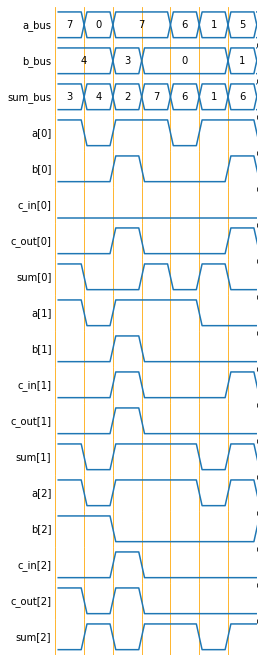

In [2]:
from myhdl import *
from myhdlpeek import Peeker

def adder_bit(a, b, c_in, sum_, c_out):
    '''Single bit adder.'''
    @always_comb
    def adder_logic():
        sum_.next = a ^ b ^ c_in
        c_out.next = (a & b) | (a & c_in) | (b & c_in)
    
    # Add some peekers to monitor the inputs and outputs.
    # These will get replicated for each adder bit.
    Peeker(a, 'a')
    Peeker(b, 'b')
    Peeker(c_in, 'c_in')
    Peeker(sum_, 'sum')
    Peeker(c_out, 'c_out')
    
    return adder_logic

def adder(a, b, sum_):
    '''Connect single-bit adders to create a complete adder.'''
    c = [Signal(bool(0)) for _ in range(len(a)+1)] # Carry signals between stages.
    s = [Signal(bool(0)) for _ in range(len(a))]   # Sum bit for each stage.
    stages = []  # Storage for adder bit instances.
    # Create the adder bits and connect them together.
    for i in range(len(a)):
        stages.append( adder_bit(a=a(i), b=b(i), sum_=s[i], c_in=c[i], c_out=c[i+1]) )
    # Concatenate the sum bits and send them out on the sum_ output.
    @always_comb
    def make_sum():
        sum_.next = ConcatSignal(*reversed(s))
    return instances()  # Return all the adder stage instances.

# Create signals for interfacing to the adder.
a, b, sum_ = [Signal(intbv(0,0,8)) for _ in range(3)]

# Clear-out any existing peeker stuff before instantiating the adder.
Peeker.clear()

# Instantiate the adder.
add_1 = adder(a=a, b=b, sum_=sum_)

# Create some more peekers to monitor the top-level buses.
Peeker(a, 'a_bus')
Peeker(b, 'b_bus')
Peeker(sum_, 'sum_bus')

# Create a testbench generator that applies random inputs to the adder.
from random import randrange
def test():
    for _ in range(8):
        a.next, b.next = randrange(0, a.max), randrange(0, a.max)
        yield delay(1)

# Simulate the adder, testbench and peekers.
Simulation(add_1, test(), *Peeker.instances()).run()

# Show all the signals in the hierarchical design.
Peeker.show_waveforms()
